### __Imports and installs__

In [15]:
from pathlib import Path
import subprocess
from tqdm import tqdm
import os

import torch
from torch.utils.data import DataLoader

from utils_dataset import CustomImageDataset, deprocess_image, load_labels
from utils_plot import show_images, show_one_image, show_cams, show_one_cam, show_centers
from utils_cam import generate_cams
from utils_models import load_model, evaluate_model_accuracy, evaluate_cross_model_accuracy
from utils_adversarial import APD, save_adversarial_images

import pandas as pd


In [2]:
batch_size = 24
num_workers = 4

gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### __Dataset__

In [17]:
models = []

resnet101 = load_model("resnet101")
models.append(resnet101)
inception_v3 = load_model("inception_v3")
models.append(inception_v3)
inception_v4 = load_model("inception_v4")
models.append(inception_v4)
adv_inception_v3 = load_model("adv_inception_v3")
models.append(adv_inception_v3)
inception_resnet_v2 = load_model("inception_resnet_v2")
models.append(inception_resnet_v2)


Loading model 'resnet101' from Model/resnet101.pth
Loading model 'inception_v3' from Model/inception_v3.pth
Loading model 'inception_v4' from Model/inception_v4.pth
Loading model 'adv_inception_v3' from Model/adv_inception_v3.pth
Loading model 'inception_resnet_v2' from Model/inception_resnet_v2.pth


In [4]:
images_folder_path = Path('tf_to_pytorch_model/dataset/images')
label_file_path = Path('tf_to_pytorch_model/dataset/dev_dataset.csv')

# Check if the images folder exists; if not, clone the repository
if not images_folder_path.exists():
    repo_url = 'https://github.com/ylhz/tf_to_pytorch_model.git'
    try:
        subprocess.run(["git", "clone", repo_url], check=True)
        print(f"Repository cloned successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to clone repository: {e}")


In [5]:
labels_dict = load_labels()

dataset = CustomImageDataset(label_file_path, images_folder_path)

dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)


Loading labels from imagenet_class_index.json


In [6]:
for model in models:
    evaluate_model_accuracy(model, dataloader, device)

Evaluating: 100%|██████████| 42/42 [00:02<00:00, 16.67it/s]


Accuracy of squeezenet: 66.8%


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 10.94it/s]


Accuracy of resnet101: 95.7%


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 11.68it/s]


Accuracy of inception_v3: 95.0%


Evaluating: 100%|██████████| 42/42 [00:06<00:00,  6.84it/s]


Accuracy of inception_v4: 94.5%


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 11.81it/s]


Accuracy of adv_inception_v3: 86.5%


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.92it/s]


Accuracy of inception_resnet_v2: 97.0%


### __Class Activation Maps__

In [7]:
# Show some images from the dataset

data_iter = iter(dataloader)
images, labels, _ = next(data_iter)

# show_images(images, labels, labels_dict, rows=2)

In [8]:
# Show grad cams for some images for each model

# for model in models:
#     model.to(device)
#     show_cams(model, images, labels, labels_dict, rows=2, image_weight=0.7)
#     model.to('cpu')


In [9]:
# idx = 17
# for model in models:
#     print(model.name)
#     show_one_cam(model, images[idx], labels[idx], image_weight=0.7)

# show_one_image(images[idx])

### __Local Maxima__

In [10]:
images, labels, _ = next(iter(dataloader))

# for model in models:
#     show_centers(model, images, labels)

### __Main algorithm__

#### Example use

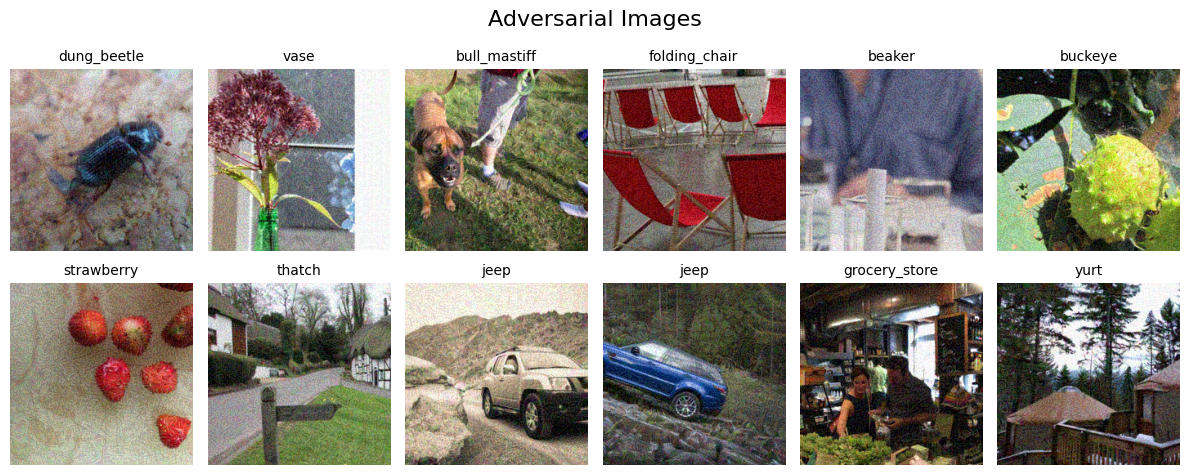

In [11]:
images, labels, _ = next(iter(dataloader))
model = squeezenet

model.to(device)
x_adv = APD(images, labels, model)
model.to('cpu')

x_adv_dep = deprocess_image(x_adv)

show_images(x_adv_dep, labels, labels_dict, title="Adversarial Images")

In [12]:
for model in models:
    save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_apd")

Directory 'Generated/squeezenet_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/resnet101_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_v3_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_v4_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/adv_inception_v3_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_resnet_v2_apd' already exists. Skipping adversarial image generation and saving.


In [13]:
for model in (m for m in models if m.name != "adv_inception_v3"):
    images_folder_path = os.path.join("Generated", f"{model.name}_apd")
    dataset = CustomImageDataset(label_file_path, images_folder_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    data_iter = iter(dataloader)
    images, labels, _ = next(data_iter)
    show_images(images, labels, labels_dict, rows=1)
    for model_target in models:
        print(f"Attacking {model_target.name} with {model.name}")
        evaluate_model_accuracy(model_target, dataloader, device)



TypeError: 'bool' object is not iterable

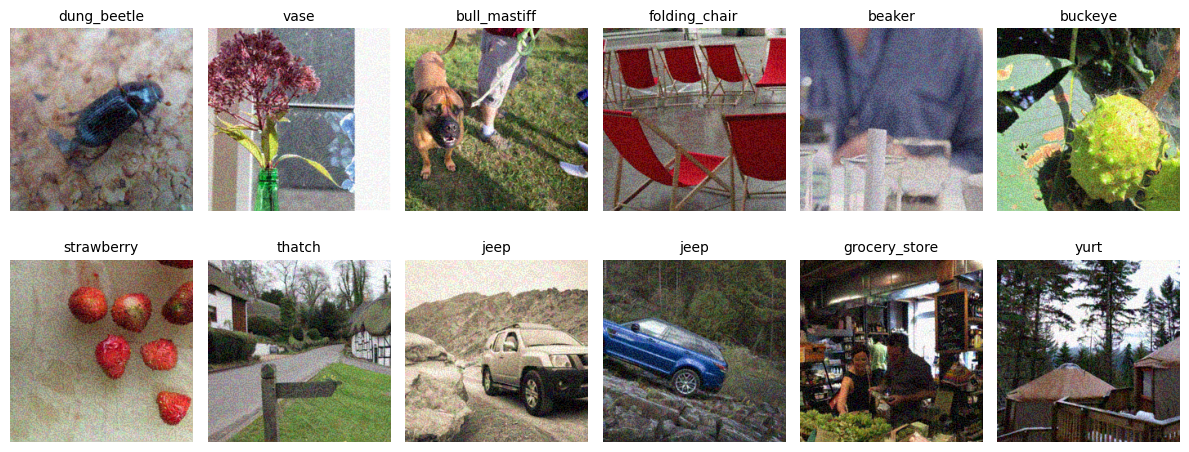

Attacking squeezenet with squeezenet


Evaluating: 100%|██████████| 42/42 [00:01<00:00, 34.91it/s]


Accuracy of squeezenet: 0.0%
Attacking resnet101 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 11.12it/s]


Accuracy of resnet101: 87.3%
Attacking inception_v3 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 11.56it/s]


Accuracy of inception_v3: 71.5%
Attacking inception_v4 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:06<00:00,  6.77it/s]


Accuracy of inception_v4: 66.1%
Attacking adv_inception_v3 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 11.60it/s]


Accuracy of adv_inception_v3: 66.8%
Attacking inception_resnet_v2 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.83it/s]


Accuracy of inception_resnet_v2: 74.1%


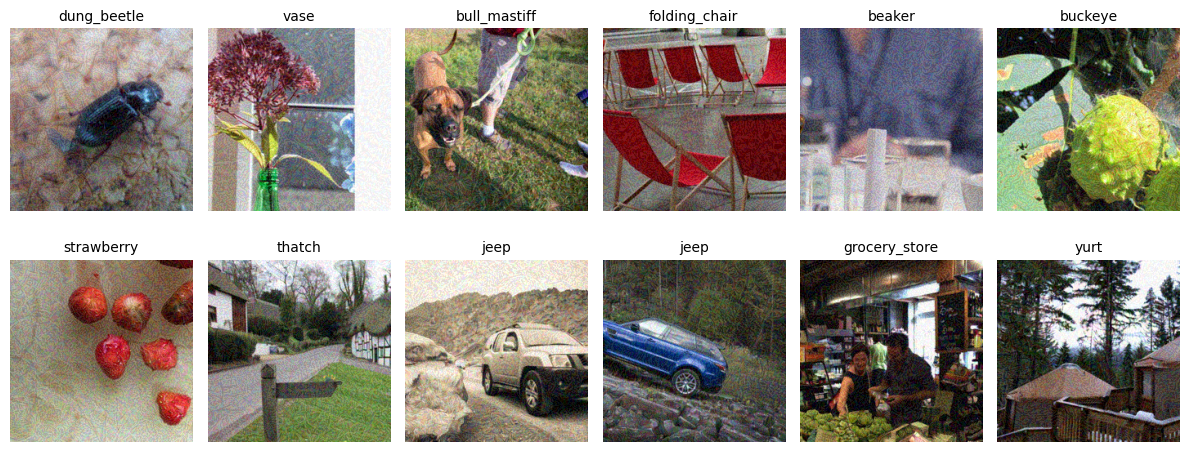

Attacking squeezenet with resnet101


Evaluating: 100%|██████████| 42/42 [00:01<00:00, 36.47it/s]


Accuracy of squeezenet: 13.6%
Attacking resnet101 with resnet101


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 11.20it/s]


Accuracy of resnet101: 0.3%
Attacking inception_v3 with resnet101


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 11.67it/s]


Accuracy of inception_v3: 39.7%
Attacking inception_v4 with resnet101


Evaluating: 100%|██████████| 42/42 [00:06<00:00,  6.88it/s]


Accuracy of inception_v4: 41.9%
Attacking adv_inception_v3 with resnet101


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 11.96it/s]


Accuracy of adv_inception_v3: 56.2%
Attacking inception_resnet_v2 with resnet101


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.90it/s]


Accuracy of inception_resnet_v2: 48.9%


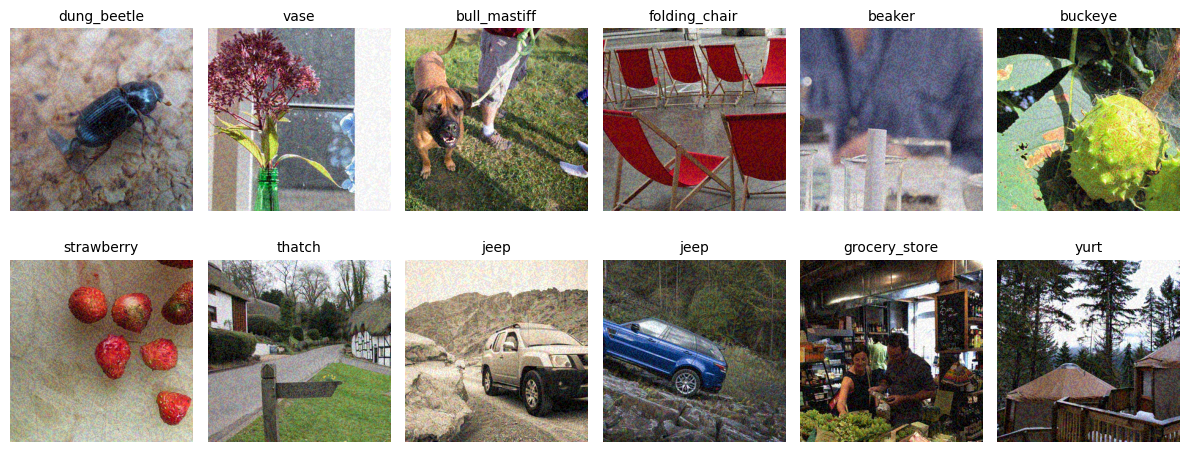

Attacking squeezenet with inception_v3


Evaluating: 100%|██████████| 42/42 [00:01<00:00, 25.26it/s]


Accuracy of squeezenet: 33.6%
Attacking resnet101 with inception_v3


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 10.60it/s]


Accuracy of resnet101: 82.9%
Attacking inception_v3 with inception_v3


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 12.09it/s]


Accuracy of inception_v3: 1.7%
Attacking inception_v4 with inception_v3


Evaluating: 100%|██████████| 42/42 [00:06<00:00,  6.93it/s]


Accuracy of inception_v4: 61.8%
Attacking adv_inception_v3 with inception_v3


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 12.08it/s]


Accuracy of adv_inception_v3: 64.4%
Attacking inception_resnet_v2 with inception_v3


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.97it/s]


Accuracy of inception_resnet_v2: 67.6%


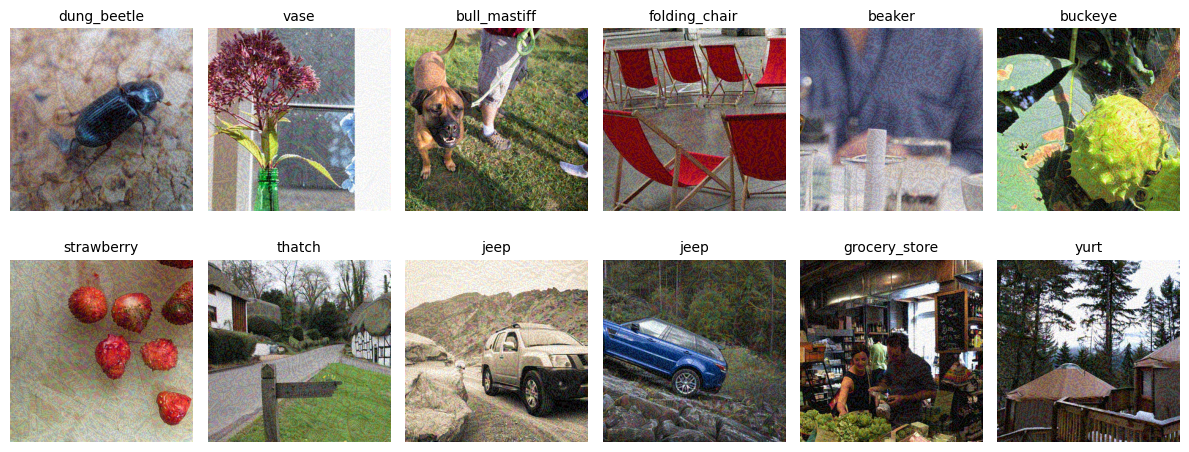

Attacking squeezenet with inception_v4


Evaluating: 100%|██████████| 42/42 [00:01<00:00, 26.28it/s]


Accuracy of squeezenet: 28.0%
Attacking resnet101 with inception_v4


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 10.70it/s]


Accuracy of resnet101: 65.5%
Attacking inception_v3 with inception_v4


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 12.32it/s]


Accuracy of inception_v3: 36.2%
Attacking inception_v4 with inception_v4


Evaluating: 100%|██████████| 42/42 [00:06<00:00,  6.97it/s]


Accuracy of inception_v4: 0.0%
Attacking adv_inception_v3 with inception_v4


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 12.17it/s]


Accuracy of adv_inception_v3: 60.8%
Attacking inception_resnet_v2 with inception_v4


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.97it/s]


Accuracy of inception_resnet_v2: 46.6%


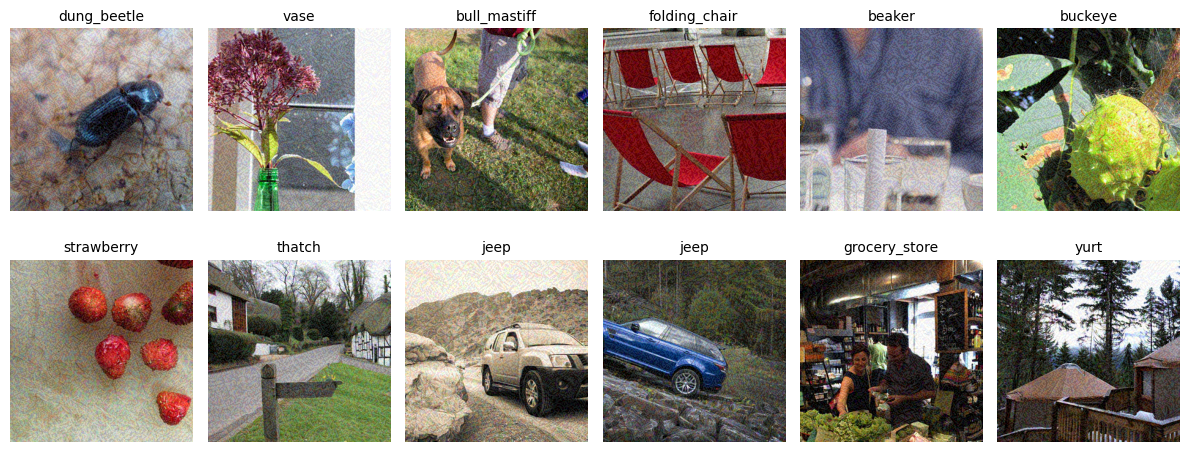

Attacking squeezenet with inception_resnet_v2


Evaluating: 100%|██████████| 42/42 [00:01<00:00, 25.44it/s]


Accuracy of squeezenet: 25.8%
Attacking resnet101 with inception_resnet_v2


Evaluating: 100%|██████████| 42/42 [00:04<00:00, 10.46it/s]


Accuracy of resnet101: 61.3%
Attacking inception_v3 with inception_resnet_v2


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 12.15it/s]


Accuracy of inception_v3: 35.3%
Attacking inception_v4 with inception_resnet_v2


Evaluating: 100%|██████████| 42/42 [00:06<00:00,  6.95it/s]


Accuracy of inception_v4: 36.0%
Attacking adv_inception_v3 with inception_resnet_v2


Evaluating: 100%|██████████| 42/42 [00:03<00:00, 12.15it/s]


Accuracy of adv_inception_v3: 54.9%
Attacking inception_resnet_v2 with inception_resnet_v2


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.98it/s]


Accuracy of inception_resnet_v2: 0.1%


TypeError: pivot() takes 1 positional argument but 4 were given

In [16]:
df_pivot = evaluate_cross_model_accuracy(models, label_file_path, batch_size, num_workers, device, "_apd")

df_pivot.to_csv("model_accuracies.csv")

In [ ]:
for model in models:
    save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_mfgsm", attack_method="MFGSM")

In [ ]:
for model in models and model.name != "adv_inception_v3":
    images_folder_path = os.path.join("Generated", f"{model.name}_mfgsm")
    dataset = CustomImageDataset(label_file_path, images_folder_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    data_iter = iter(dataloader)
    images, labels, _ = next(data_iter)
    show_images(images, labels, labels_dict, rows=2)
    for model_target in models:
        print(f"Attacking {model_target.name} with {model.name}")
        evaluate_model_accuracy(model_target, dataloader, device)

TODO : clamp avec bonnes valeurs et adapter eps en conséquence (done!);, Essayer moyenner x_adv sur différents modèles !!
IDEES AMELIO : rescale dans algo (done), gradCAM (RDFIA) en + de gradCAM++ (done); threshold au lieu de région carrée pour régions dropout (done), tester en mettant le gradient à 0 dans les régions dropped out (done)